In [34]:
import re
from abc import *
from typing import *
import numpy as np
import scipy as sp
import mne
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from typing import List, Tuple
from sklearn.model_selection import train_test_split
from nodestimation.learning.selection import collect_statistic, \
    compute_importance, collect_cross_statistic, make_selection_map, \
    select, separate_datasets, selected_statistic, choose_best, selected_data, make_feature_selection
from nodestimation.project import  find_subject_dir
from nodestimation.pipeline import pipeline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import nilearn.plotting as nplt
from nodestimation.project.actions import read
import nodestimation as nd
from nodestimation.learning.selection import append_series
from nodestimation.project.subject import Subject
from sklearn.preprocessing import *
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib as mpl

subjects = pipeline(methods=['wpli', 'psd', 'envelope', 'imcoh', 'ciplv'],
                    freq_bands=[(0.5, 4), (4, 7), (7, 14), (14, 30), (30, 70)])
for subject in subjects:
    s1 = subject.dataset['4-7Hz_wpli']
    s2 = subject.dataset['4-7Hz_imcoh']
    print(s1.corr(s2))


All computation has been already done, loading of the existing file with the solution...
-0.062040711226396976
-0.021675951360116952
0.1820987552014157
0.26807551557549236
0.18501937044985142
0.3023986126566316
0.0066680979084103855
0.006199363044530616
0.34801060203878004
-0.061699491098473044
0.1442026668593891
0.21640016795768832
0.02621894017328957
-0.008971380231130054
0.15216139629499356
0.21510705631361435


In [30]:
dataset = pd.concat(
    [subject.dataset
    for subject in subjects],
    axis=0,
    )

new_indexes = list()

for subject in subjects:
    for index in subject.dataset.index:
        new_indexes.append('_'.join([subject.name, index]))

dataset = pd.DataFrame(dataset.to_numpy(), columns=dataset.columns, index=new_indexes)

                              0.5-4Hz_wpli 0.5-4Hz_psd 0.5-4Hz_imcoh  \
M2S2_G&S_cingul-Ant-lh            0.076139   28.316203     -0.036816   
M2S2_G&S_cingul-Ant-rh            0.083539   25.325905     -0.049774   
M2S2_G&S_cingul-Mid-Ant-lh        0.095494   17.506609     -0.096008   
M2S2_G&S_cingul-Mid-Ant-rh        0.082593   17.897155     -0.041688   
M2S2_G&S_cingul-Mid-Post-lh       0.090825   16.614113     -0.081443   
...                                    ...         ...           ...   
L2M1_S_temporal_sup-rh            0.101591   12.351377     -0.001339   
L2M1_S_temporal_transverse-lh     0.084187   18.143175      0.084519   
L2M1_S_temporal_transverse-rh     0.088432    10.94927      0.029744   
L2M1_Unknown-lh                   0.079711   10.449549      0.099734   
L2M1_Unknown-rh                   0.084973   12.451854      0.117139   

                              0.5-4Hz_ciplv 4-7Hz_wpli  4-7Hz_psd 4-7Hz_imcoh  \
M2S2_G&S_cingul-Ant-lh             0.093158   0.078681

In [4]:
true_cases, false_cases = pd.DataFrame(), pd.DataFrame()

for index in dataset.index:
    if dataset.loc[index]['resected']:
        true_cases = append_series(true_cases, dataset.loc[index])
    else:
        false_cases = append_series(false_cases, dataset.loc[index])


In [5]:
def postfix(name:str) -> str:
    if name[-2:] == 'rh':
        return 'lh'
    elif name[-2:] == 'lh':
        return 'rh'
    else:
        raise ValueError(name[-2:])

def prefix(name: str, subjects: List[Subject]) -> str:
    label_name = name[5:-2] + postfix(name)
    for subject in subjects:
        if subject.dataset.loc[label_name]['resected']:
            continue
        else:
            return subject.name
    raise ValueError('label' + name[4:] + ' not found')

true_data = true_cases.drop(['resected'], axis=1)
false_data = false_cases.drop(['resected'], axis=1)
print(false_data.shape)
false_data_symmetric = pd.DataFrame()

for index in true_data.index:
    try:
        false_data_symmetric = pd.concat(
            [
                false_data_symmetric,
                false_data.loc[index[0:-2] + postfix(index)]
            ],
            axis=1
        )
    except KeyError:
        false_data_symmetric = pd.concat(
            [
                false_data_symmetric,
                false_data.loc[prefix(index, subjects) + index[4:-2] + postfix(index)]
            ],
            axis=1
        )
print(false_data_symmetric.T.shape, true_data.shape)
false_data_np,\
false_data_symmetric_np,\
true_data_np\
    =\
    false_data.to_numpy().T,\
    false_data_symmetric.to_numpy(),\
    true_data.to_numpy().T

print(false_data_np.shape, false_data_symmetric_np.shape, true_data_np.shape)

(2358, 21)
(42, 21) (42, 21)
(21, 2358) (21, 42) (21, 42)


In [6]:
from scipy.stats import wilcoxon
for i in range(len(dataset.columns) - 1):
    w, p = wilcoxon(false_data_symmetric_np[i, :], true_data_np[i, :])
    print('\n******************\n'
          'Wilcoxon for mirror\n'
          'Feature: {}\n'
          'Statistic: {}\n'
          'P-value: {}'
          .format(dataset.columns[i],
                  w,
                  p))


******************
Wilcoxon for mirror
Feature: 0.5-4Hz_wpli
Statistic: 414.0
P-value: 0.6391501305851586

******************
Wilcoxon for mirror
Feature: 0.5-4Hz_psd
Statistic: 288.0
P-value: 0.04091907995939848

******************
Wilcoxon for mirror
Feature: 0.5-4Hz_imcoh
Statistic: 325.0
P-value: 0.11371499844448898

******************
Wilcoxon for mirror
Feature: 0.5-4Hz_ciplv
Statistic: 431.0
P-value: 0.7976998126836164

******************
Wilcoxon for mirror
Feature: 4-7Hz_wpli
Statistic: 171.0
P-value: 0.00045271647838720206

******************
Wilcoxon for mirror
Feature: 4-7Hz_psd
Statistic: 430.0
P-value: 0.7880614528059118

******************
Wilcoxon for mirror
Feature: 4-7Hz_imcoh
Statistic: 257.0
P-value: 0.015017258141279547

******************
Wilcoxon for mirror
Feature: 4-7Hz_ciplv
Statistic: 447.0
P-value: 0.9551295162314712

******************
Wilcoxon for mirror
Feature: 7-14Hz_wpli
Statistic: 262.0
P-value: 0.017814839449509

******************
Wilcoxon for mirr

In [ ]:
# a = pd.concat(
#             [
#                 true_data[true_data.columns[1]],
#                 false_data[true_data.columns[1]],
#             ],
#             axis=1
#         )


In [7]:
def rm(array: Union[list, np.ndarray], indexes:Union[int, List[int]]) -> any:
    if not isinstance(indexes, list):
        indexes = [indexes]
    if isinstance(array, np.ndarray):
        array = array.tolist()
    for index in indexes:
        if index < len(array):
            array[index] = None
        else:
            continue
    return np.array([item for item in array if item is not None])

def choose_items(array: np.ndarray, number: int, axis=0) -> List[int]:
    return [np.random.randint(array.shape[axis]) for i in range(number)]


data_for_resampling = false_data_np.copy()
bands = list()

for i in range(false_data_np.shape[1]//true_data_np.shape[1]):
    indexes = choose_items(data_for_resampling, true_data_np.shape[1], axis=1)
    choose = list()

    for index in indexes:
        choose.append(data_for_resampling[:, index])
    data_for_resampling = data_for_resampling.tolist()
    for datasample in data_for_resampling:
            # datasample = rm(datasample, true_data_np.shape[1])
            datasample = rm(datasample.copy(), indexes)
    data_for_resampling = np.array(data_for_resampling)
    bands.append(np.array(choose))
bands = np.array(bands)

resampled_false = np.mean(bands, axis=0)
resampled_false_df = pd.DataFrame(resampled_false, columns=true_data.columns)

In [8]:
for i in range(len(dataset.columns) - 1):
    w, p = wilcoxon(resampled_false[:, i], true_data_np[i, :])
    print('\n******************\n'
          'Wilcoxon for all\n'
          'Feature: {}\n'
          'Statistic: {}\n'
          'P-value: {}'
          .format(dataset.columns[i],
                  w,
                  p))



******************
Wilcoxon for all
Feature: 0.5-4Hz_wpli
Statistic: 395.0
P-value: 0.47990398439711157

******************
Wilcoxon for all
Feature: 0.5-4Hz_psd
Statistic: 372.0
P-value: 0.3202027778610119

******************
Wilcoxon for all
Feature: 0.5-4Hz_imcoh
Statistic: 330.0
P-value: 0.12871338379943947

******************
Wilcoxon for all
Feature: 0.5-4Hz_ciplv
Statistic: 398.0
P-value: 0.5035299195137813

******************
Wilcoxon for all
Feature: 4-7Hz_wpli
Statistic: 228.0
P-value: 0.00519689746784095

******************
Wilcoxon for all
Feature: 4-7Hz_psd
Statistic: 415.0
P-value: 0.6481140664101346

******************
Wilcoxon for all
Feature: 4-7Hz_imcoh
Statistic: 250.0
P-value: 0.01175255663572911

******************
Wilcoxon for all
Feature: 4-7Hz_ciplv
Statistic: 398.0
P-value: 0.5035299195137813

******************
Wilcoxon for all
Feature: 7-14Hz_wpli
Statistic: 333.0
P-value: 0.1384243562139118

******************
Wilcoxon for all
Feature: 7-14Hz_psd
Statistic:

In [26]:
for i in range(len(dataset.columns) - 1):
    ws, ps = wilcoxon(false_data_symmetric_np[i, :], true_data_np[i, :])
    wa, pa = wilcoxon(resampled_false[:, i], true_data_np[i, :])
    if pa < 0.075 and ps < 0.075:
        print('\n*************************************************************\n'
          'Feature: {}\n'
          '                 symmetric                      all\n'
          'Statistic:        {}                         {}\n'
          'P-value:    {}      {}'
          .format(dataset.columns[i],
                  ws, wa,
                  ps, pa))



*************************************************************
Feature: 4-7Hz_wpli
                 symmetric                      all
Statistic:        171.0                         228.0
P-value:    0.00045271647838720206      0.00519689746784095

*************************************************************
Feature: 4-7Hz_imcoh
                 symmetric                      all
Statistic:        257.0                         250.0
P-value:    0.015017258141279547      0.01175255663572911

*************************************************************
Feature: 7-14Hz_imcoh
                 symmetric                      all
Statistic:        303.0                         295.0
P-value:    0.06334045881003546      0.0503682382022735


<ipython-input-41-f80839e361f4>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(11, 6))


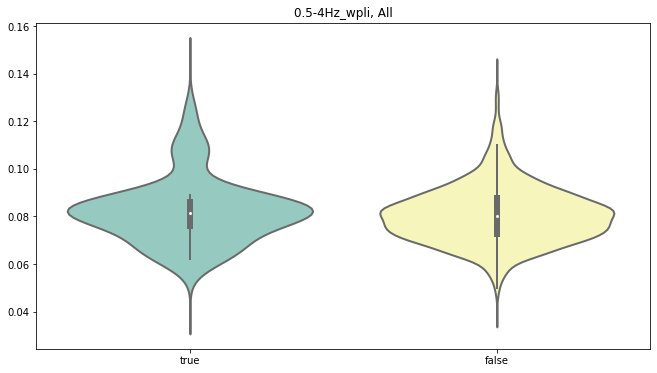

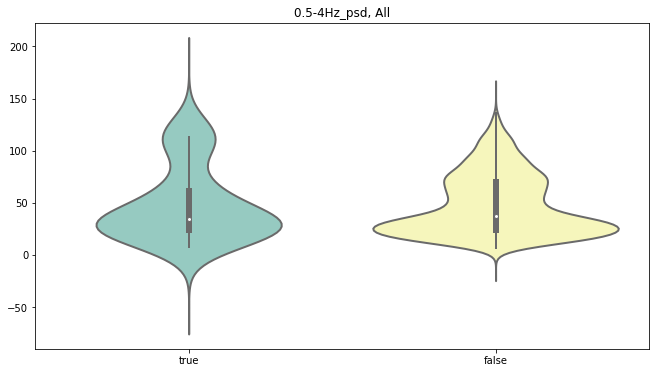

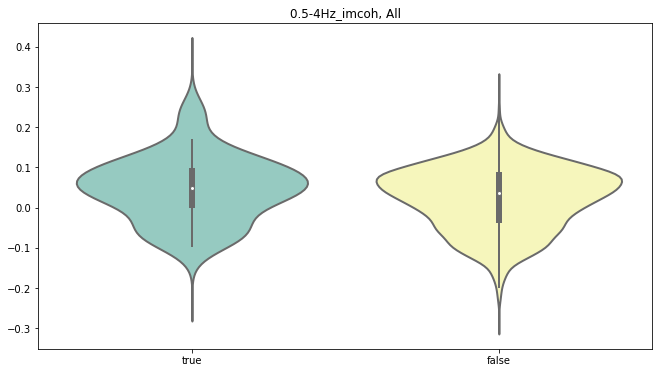

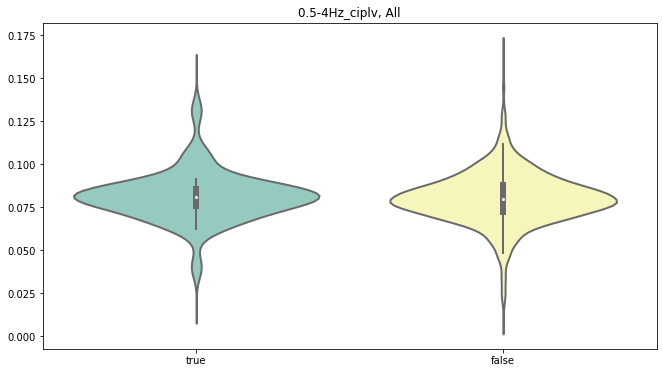

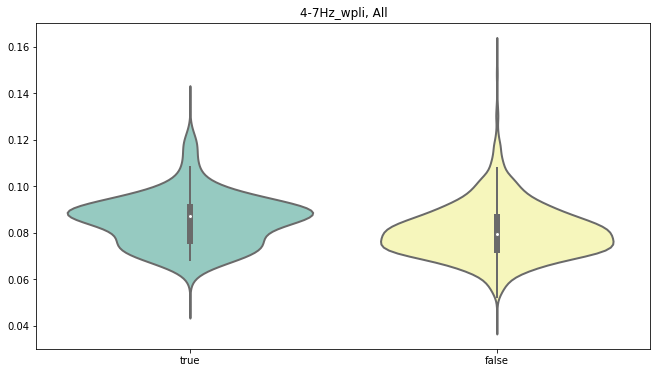

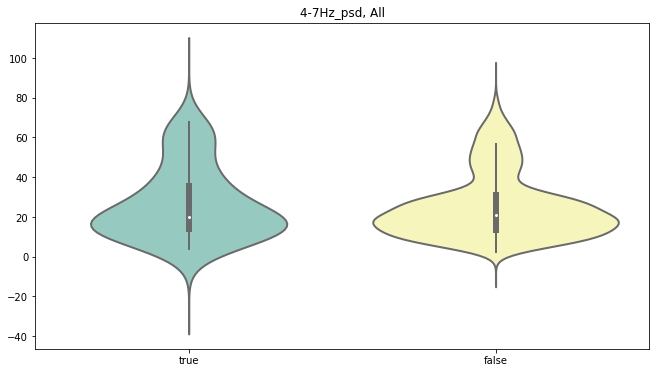

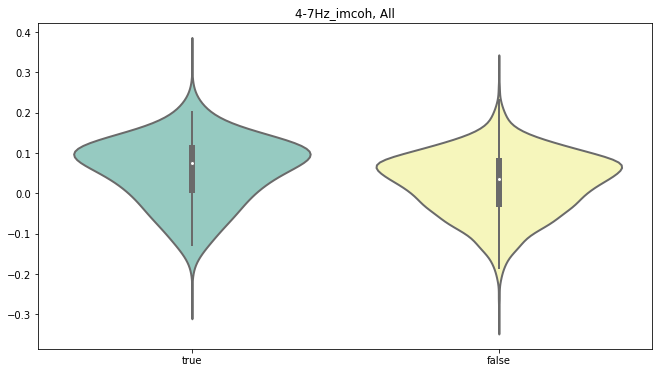

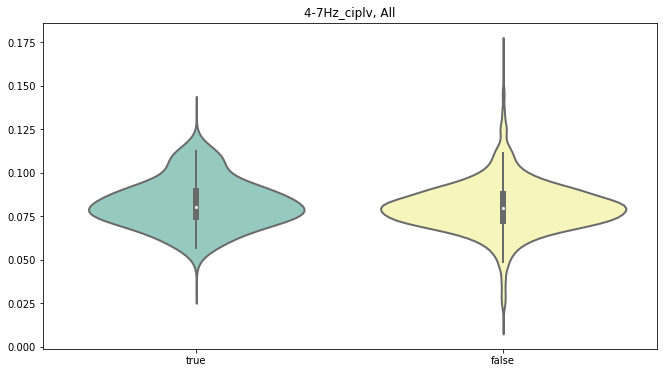

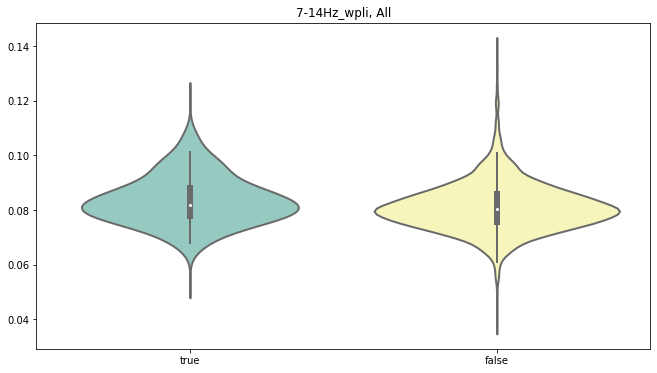

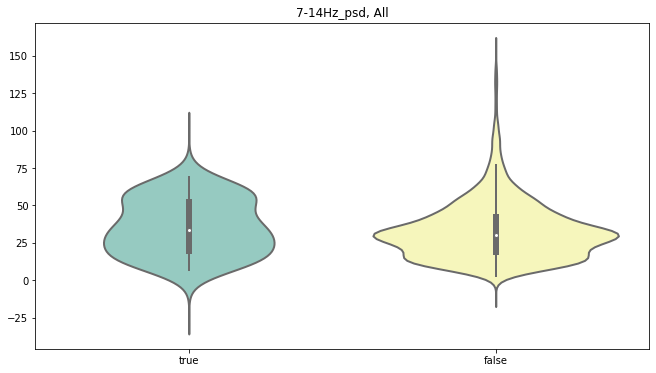

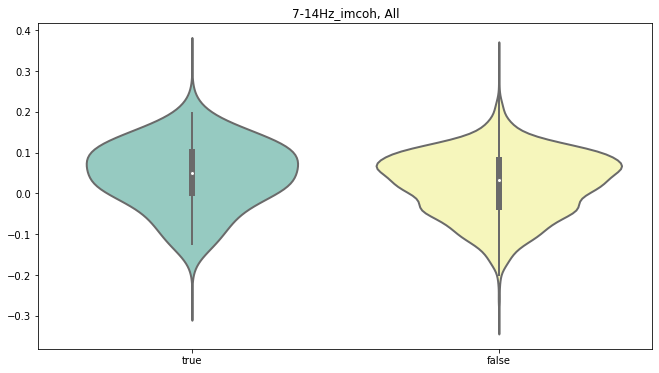

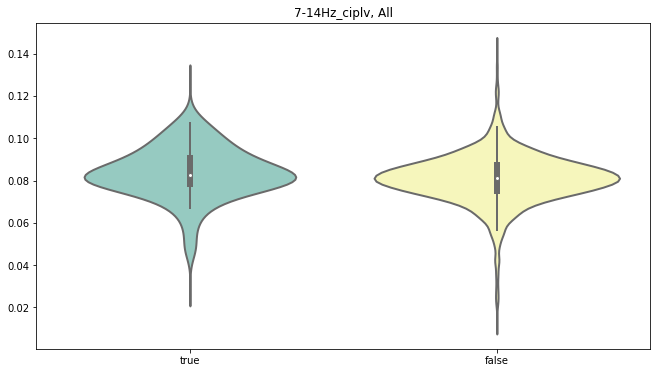

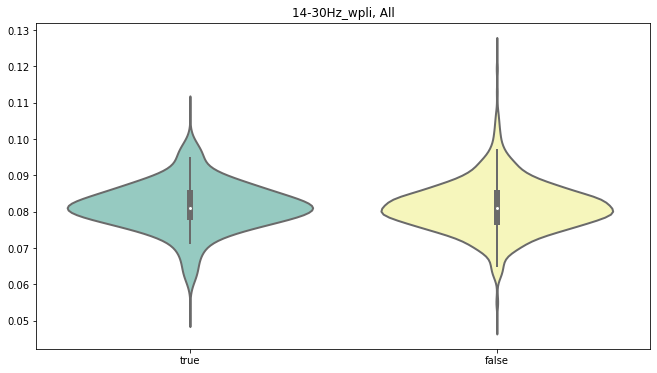

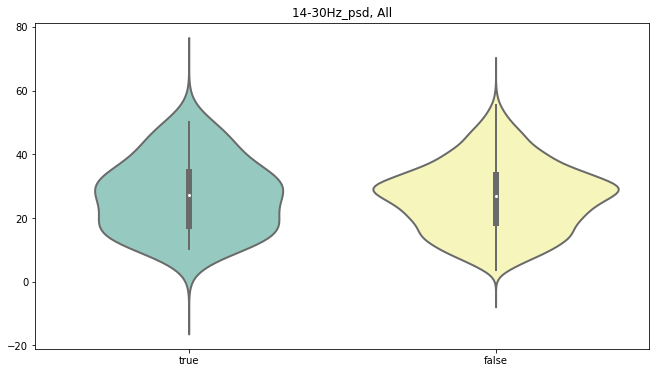

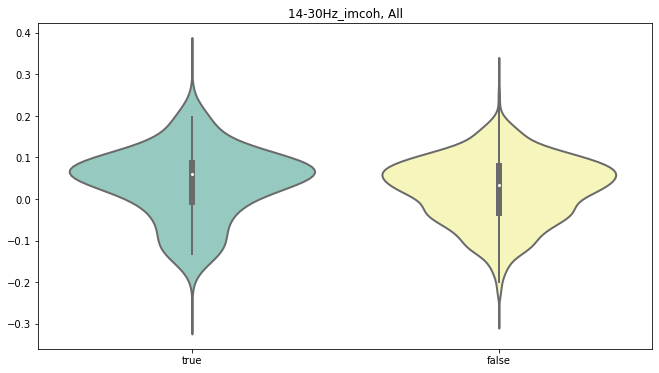

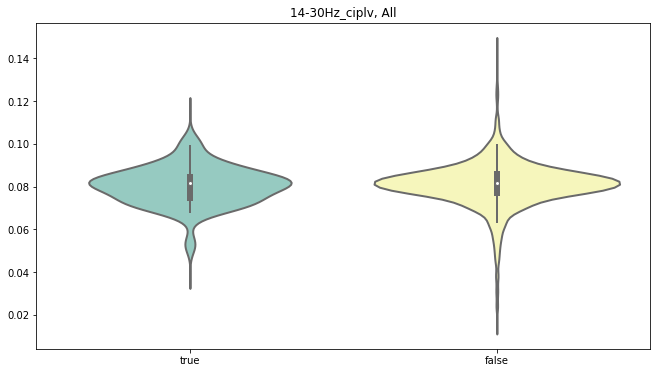

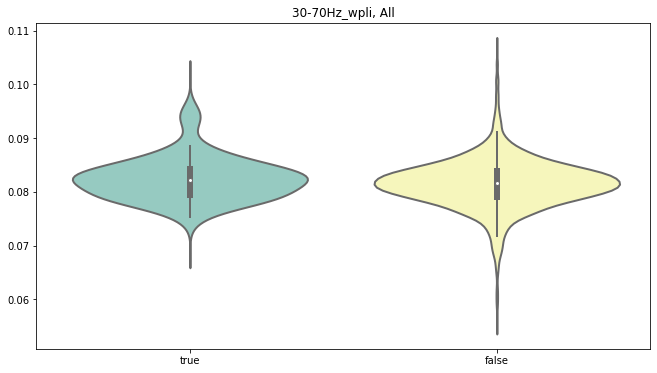

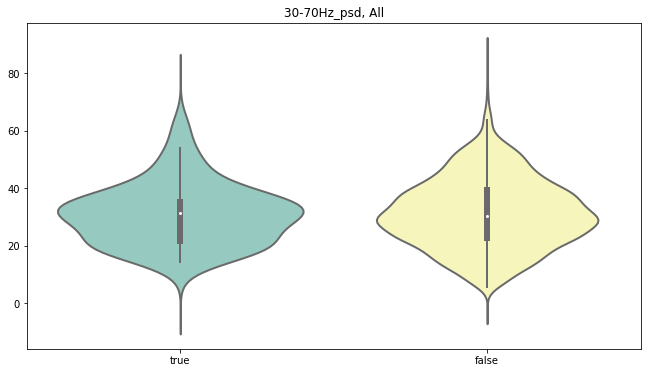

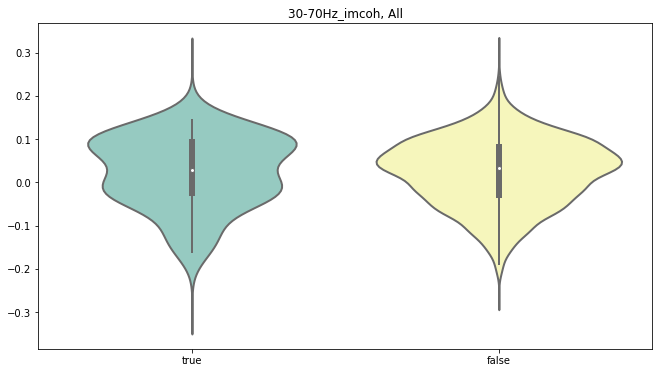

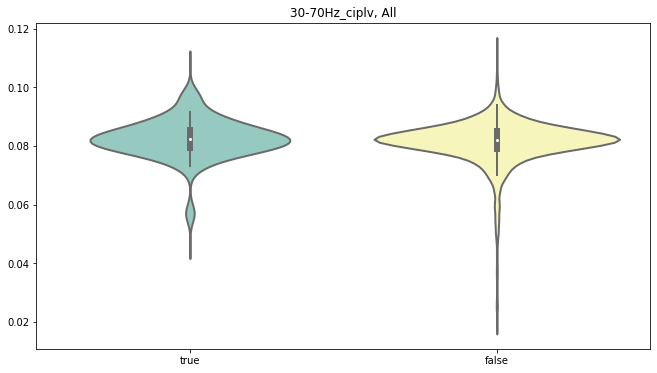

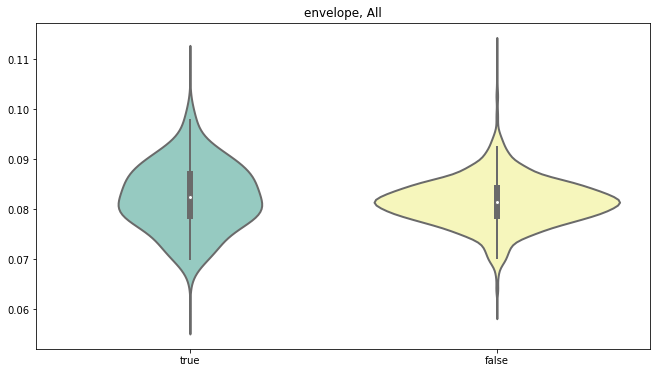

In [41]:
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'

for i in range(len(true_data.columns)):
    f, ax = plt.subplots(figsize=(11, 6))
    sns.violinplot(
        data=[
            true_data[true_data.columns[i]].to_numpy(),
            false_data[false_data.columns[i]].to_numpy(),
        ],
        palette="Set3",
        bw='scott',
        cut=5,
        linewidth=2,
    )
    labels = ['true', 'false']
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels= labels)
    ax.set_title(true_data.columns[i] + ', All')

<ipython-input-42-5dd1f80767c8>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(11, 6))


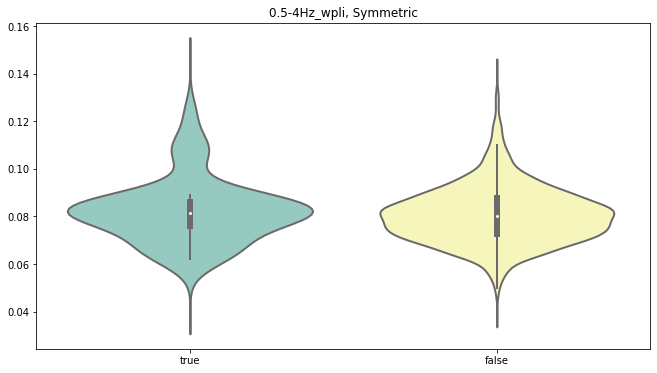

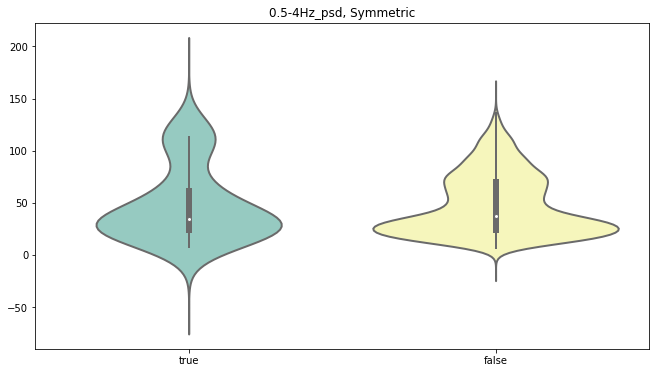

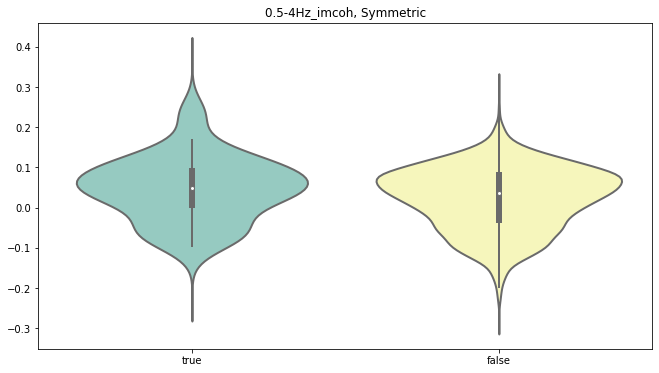

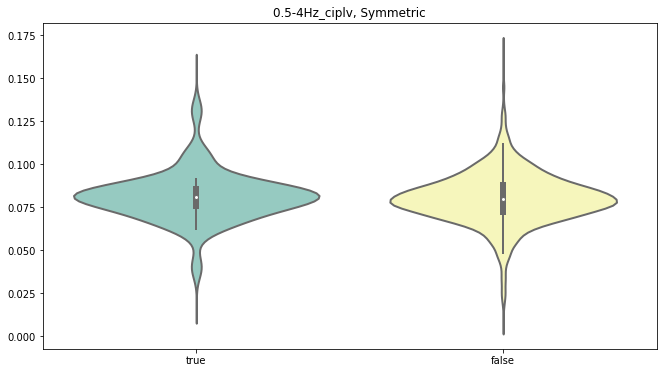

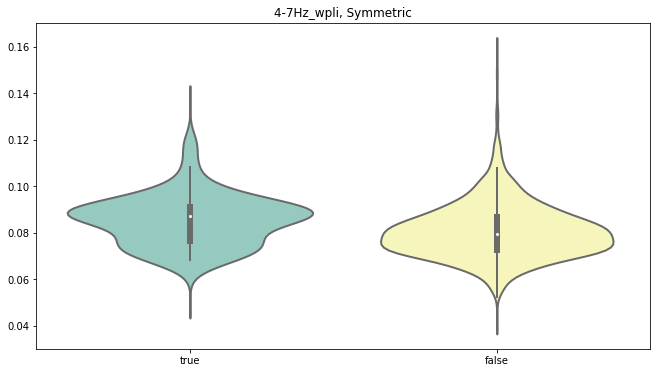

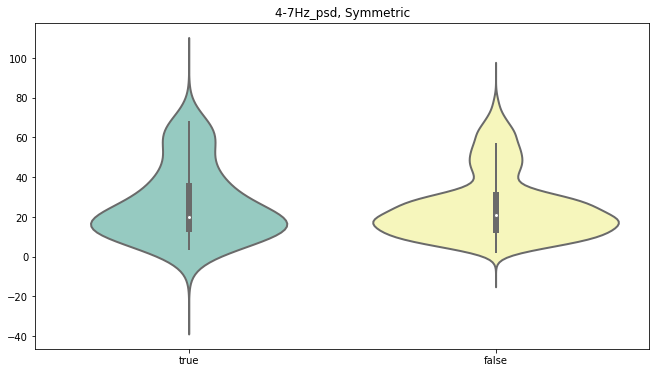

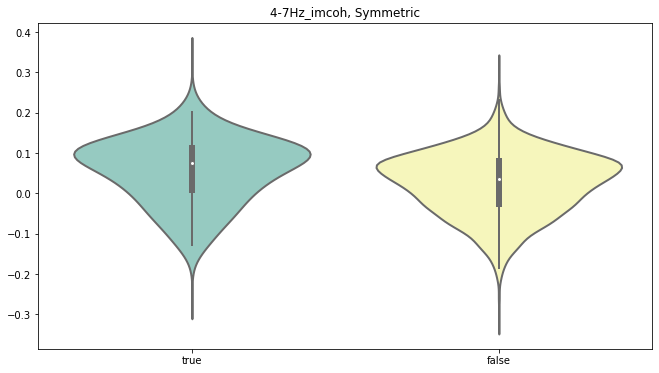

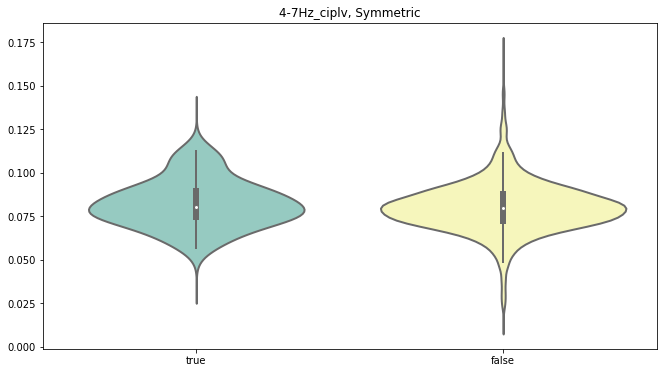

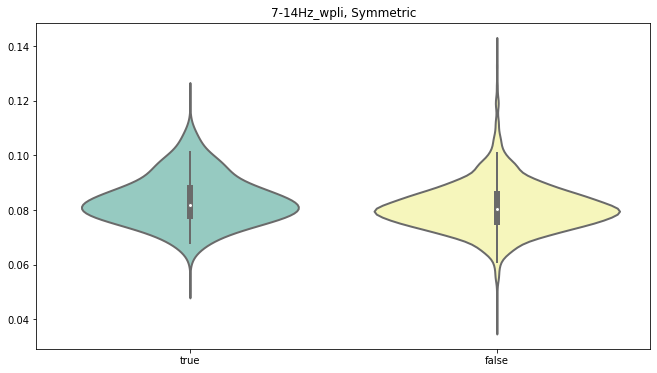

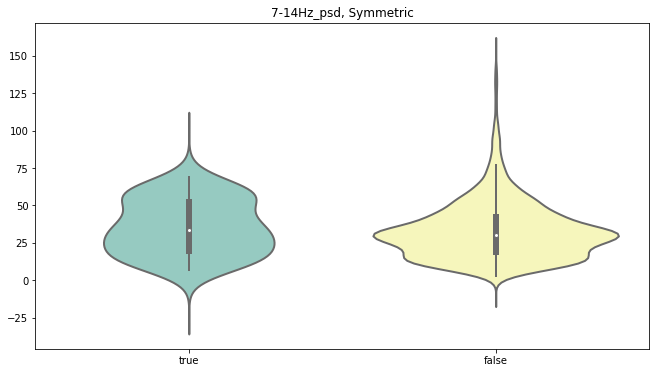

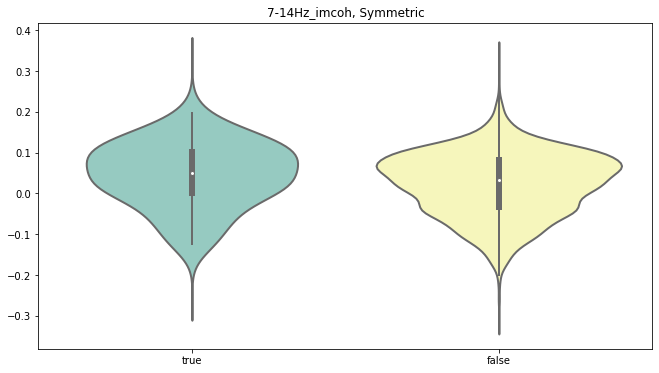

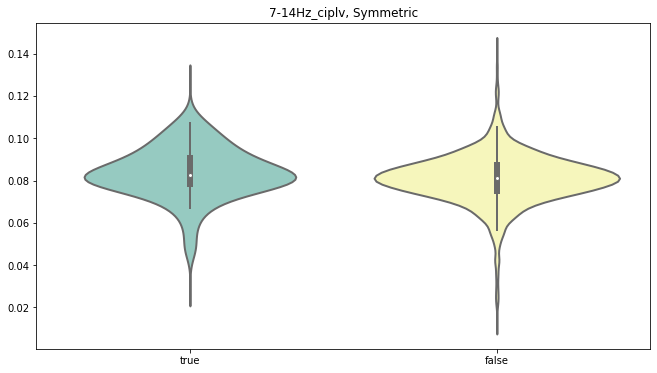

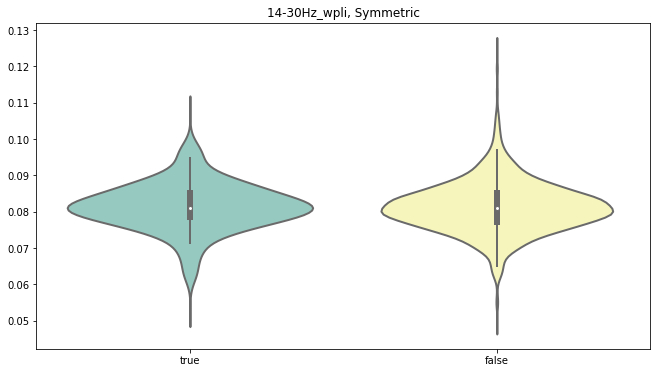

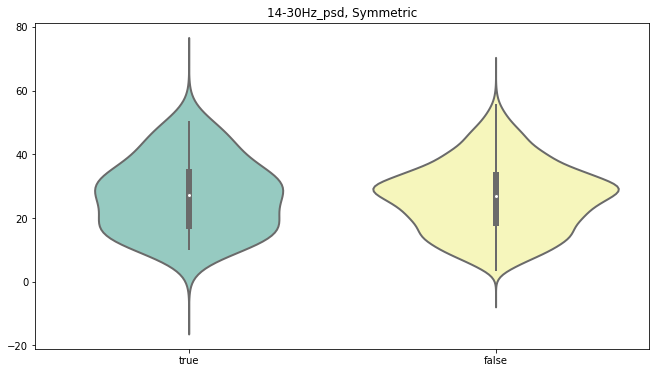

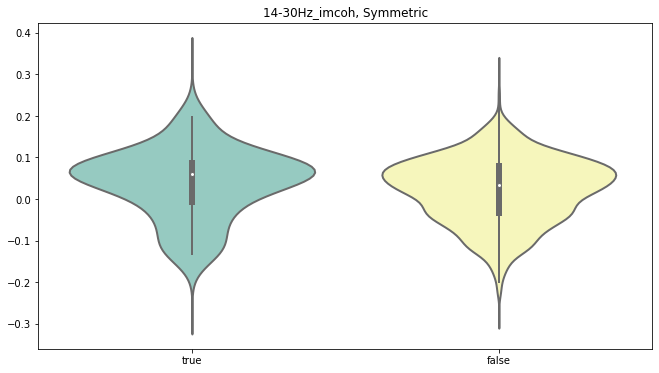

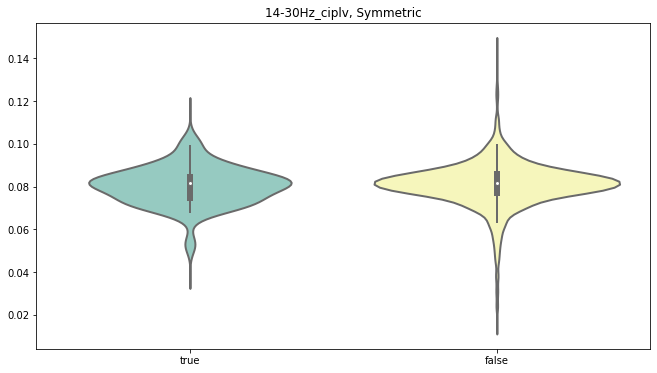

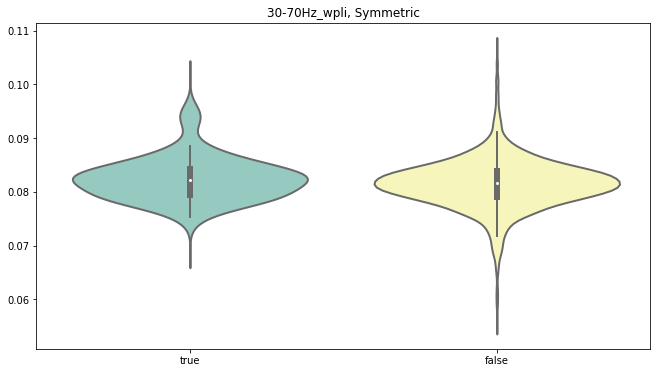

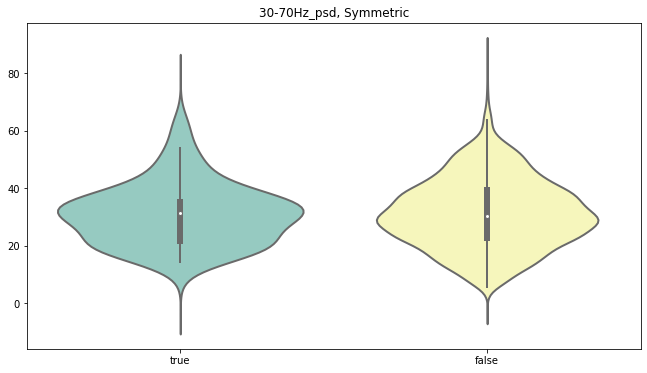

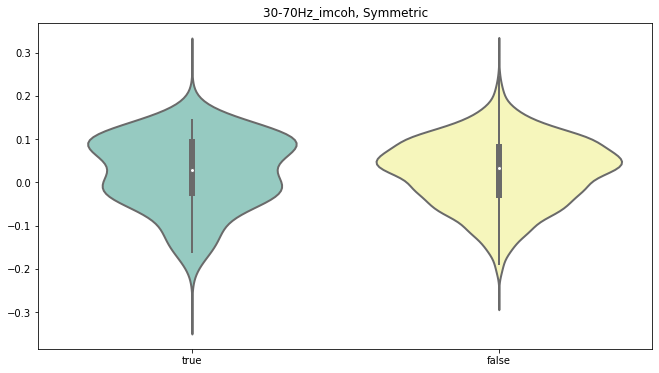

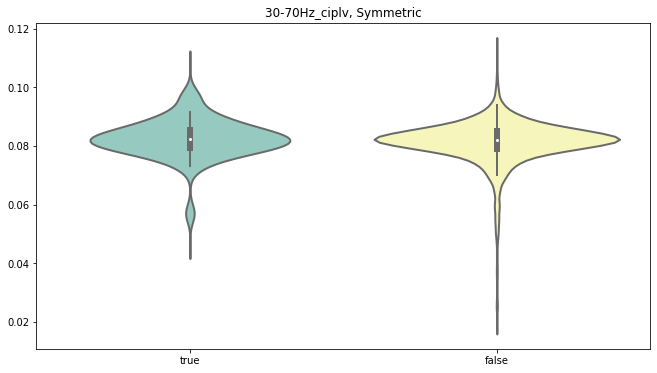

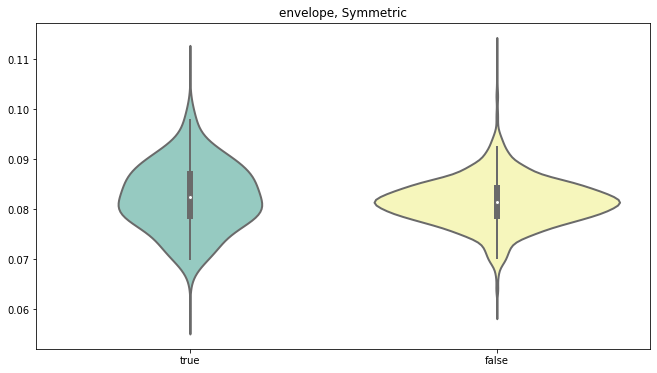

In [42]:
# mpl.rcParams['text.color'] = 'w'
# mpl.rcParams['xtick.color'] = 'w'
# mpl.rcParams['ytick.color'] = 'w'
# mpl.rcParams['axes.labelcolor'] = 'w'

for i in range(len(true_data.columns)):
    f, ax = plt.subplots(figsize=(11, 6))
    sns.violinplot(
        data=[
            true_data[true_data.columns[i]].to_numpy(),
            false_data[false_data_symmetric.T.columns[i]].to_numpy(),
        ],
        palette="Set3",
        bw='scott',
        cut=5,
        linewidth=2,
    )
    labels = ['true', 'false']
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels= labels)
    ax.set_title(true_data.columns[i] + ', Symmetric')

<ipython-input-43-e3629b0f8bee>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(11, 6))


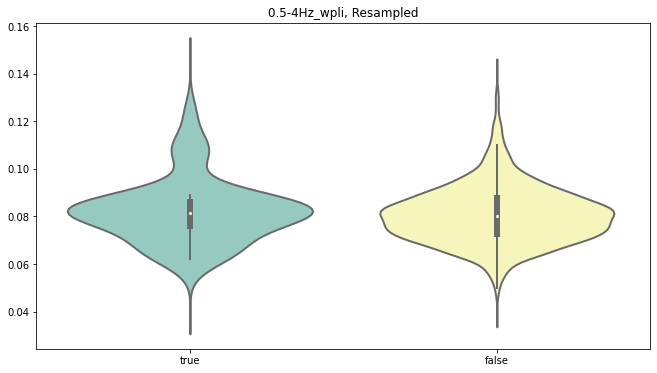

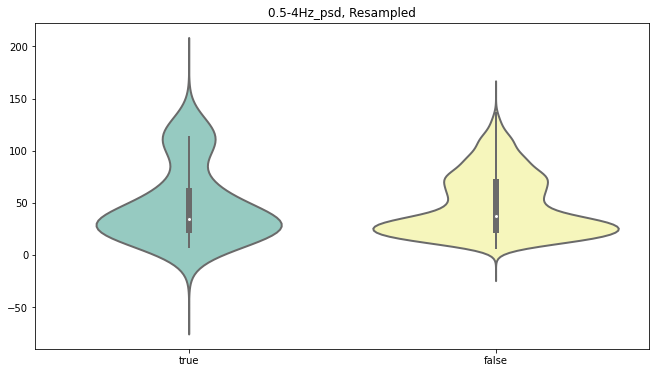

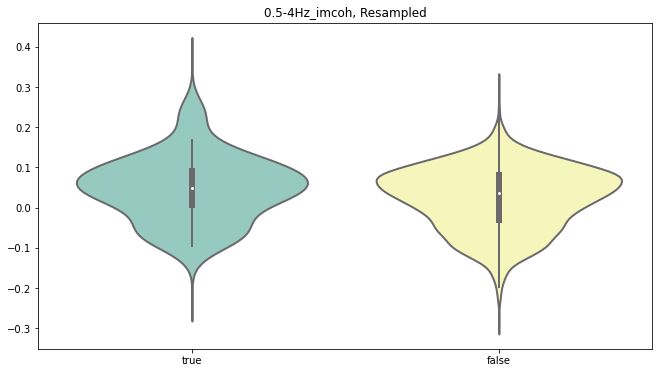

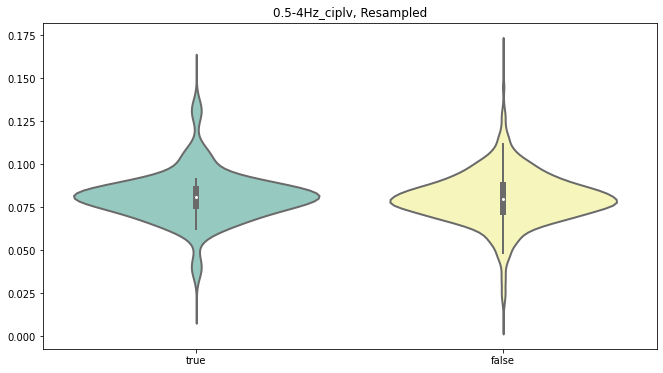

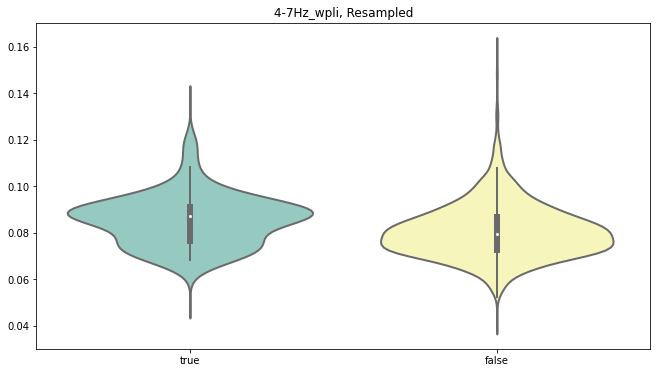

In [ ]:
# mpl.rcParams['text.color'] = 'w'
# mpl.rcParams['xtick.color'] = 'w'
# mpl.rcParams['ytick.color'] = 'w'
# mpl.rcParams['axes.labelcolor'] = 'w'

for i in range(len(true_data.columns)):
    f, ax = plt.subplots(figsize=(11, 6))
    sns.violinplot(
        data=[
            true_data[true_data.columns[i]].to_numpy(),
            false_data[resampled_false_df.columns[i]].to_numpy(),
        ],
        palette="Set3",
        bw='scott',
        cut=5,
        linewidth=2,
    )
    labels = ['true', 'false']
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels= labels)
    ax.set_title(true_data.columns[i] + ', Resampled')

In [ ]:
x = list()
y = list()
add_false = False
for subject in subjects[:len(subjects)-1]:
    for i in subject.dataset.index:
        if subject.dataset.iloc[i]['resected']:
            x.append(subject.dataset.drop(['resected'], axis=1).iloc[i].tolist())
            y.append(int(subject.dataset.iloc[i]['resected']))
            add_false = True
        elif add_false:
            x.append(subject.dataset.drop(['resected'], axis=1).iloc[i].tolist())
            y.append(int(subject.dataset.iloc[i]['resected']))
            add_false = False

x_real = subjects[-1].dataset.drop(['resected'], axis=1).values.tolist()
y_real = [int(sample) for sample in subjects[-1].dataset['resected']]
# true cases: 145, 147

st_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
ma_scaler = MaxAbsScaler()
rb_scaler = RobustScaler()

x_st_sc = st_scaler.fit_transform(x)
x_real_st_sc = st_scaler.fit_transform(x_real)
x_mm_sc = mm_scaler.fit_transform(x)
x_real_mm_sc = mm_scaler.fit_transform(x_real)
x_ma_sc = ma_scaler.fit_transform(x)
x_real_ma_sc = ma_scaler.fit_transform(x_real)
x_rb_sc = rb_scaler.fit_transform(x)
x_real_rb_sc = rb_scaler.fit_transform(x_real)

x_train, x_test, y_train, y_test  = train_test_split(x, y)
x_train_st_sc, x_test_st_sc, y_train_st_sc, y_test_st_sc  = train_test_split(x_st_sc, y)
x_train_mm_sc, x_test_mm_sc, y_train_mm_sc, y_test_mm_sc  = train_test_split(x_mm_sc, y)
x_train_ma_sc, x_test_ma_sc, y_train_ma_sc, y_test_ma_sc  = train_test_split(x_ma_sc, y)
x_train_rb_sc, x_test_rb_sc, y_train_rb_sc, y_test_rb_sc  = train_test_split(x_rb_sc, y)

In [ ]:
print('*'*50)





In [ ]:
x_train_st_sc_true = [x for x, y in zip(x_train_st_sc, y_train_st_sc) if y == 1]
x_train_st_sc_false = [x for x, y in zip(x_train_st_sc, y_train_st_sc) if y == 0]
x_train_st_sc_true = x_train_st_sc_true[0:len(x_train_st_sc_false)]
plt.xlabel('features')
plt.ylabel('values')
plt.plot(
    range(x_train_st_sc_true[0].shape[0]), x_train_st_sc_true[0], 'g',
    range(x_train_st_sc_false[0].shape[0]), x_train_st_sc_false[0], 'r',
    range(x_train_st_sc_true[1].shape[0]), x_train_st_sc_true[1], 'g',
    range(x_train_st_sc_false[1].shape[0]), x_train_st_sc_false[1], 'r',
    range(x_train_st_sc_true[2].shape[0]), x_train_st_sc_true[2], 'g',
    range(x_train_st_sc_false[2].shape[0]), x_train_st_sc_false[2], 'r',
    range(x_train_st_sc_true[3].shape[0]), x_train_st_sc_true[3], 'g',
    range(x_train_st_sc_false[3].shape[0]), x_train_st_sc_false[3], 'r',
    range(x_train_st_sc_true[4].shape[0]), x_train_st_sc_true[4], 'g',
    range(x_train_st_sc_false[4].shape[0]), x_train_st_sc_false[4], 'r',
    range(x_train_st_sc_true[5].shape[0]), x_train_st_sc_true[5], 'g',
    range(x_train_st_sc_false[5].shape[0]), x_train_st_sc_false[5], 'r',
    range(x_train_st_sc_true[6].shape[0]), x_train_st_sc_true[6], 'g',
    range(x_train_st_sc_false[6].shape[0]), x_train_st_sc_false[6], 'r',
    range(x_train_st_sc_true[7].shape[0]), x_train_st_sc_true[7], 'g',
    range(x_train_st_sc_false[7].shape[0]), x_train_st_sc_false[7], 'r',
    range(x_train_st_sc_true[8].shape[0]), x_train_st_sc_true[8], 'g',
    range(x_train_st_sc_false[8].shape[0]), x_train_st_sc_false[8], 'r',
    range(x_train_st_sc_true[9].shape[0]), x_train_st_sc_true[9], 'g',
    range(x_train_st_sc_false[9].shape[0]), x_train_st_sc_false[9], 'r',
    range(x_train_st_sc_true[10].shape[0]), x_train_st_sc_true[10], 'g',
    range(x_train_st_sc_false[10].shape[0]), x_train_st_sc_false[10], 'r',
    range(x_train_st_sc_true[11].shape[0]), x_train_st_sc_true[11], 'g',
    range(x_train_st_sc_false[11].shape[0]), x_train_st_sc_false[11], 'r',
    range(x_train_st_sc_true[12].shape[0]), x_train_st_sc_true[12], 'g',
    range(x_train_st_sc_false[12].shape[0]), x_train_st_sc_false[12], 'r',
)
plt.show()
# print(len(x_train_st_sc_true), ', ', len(x_train_st_sc_false))

In [ ]:
x_train_st_sc_true = np.array(x_train_st_sc_true)
x_train_st_sc_false = np.array(x_train_st_sc_false)
# print(x_train_st_sc_true.shape, x_train_st_sc_false.shape)
wpli05_4Hz_true = x_train_st_sc_true[0, :]
psd05_4Hz_true = x_train_st_sc_true[1, :]
wpli05_4Hz_false = x_train_st_sc_false[0, :]
psd05_4Hz_false = x_train_st_sc_false[1, :]
plt.xlabel('psd')
plt.ylabel('wpli')
plt.plot(psd05_4Hz_true, wpli05_4Hz_true, '.g',
         psd05_4Hz_false, wpli05_4Hz_false, '.r')

In [ ]:
x_train_st_sc_true = np.array(x_train_st_sc_true)
x_train_st_sc_false = np.array(x_train_st_sc_false)
# print(x_train_st_sc_true.shape, x_train_st_sc_false.shape)
wpli4_7Hz_true = x_train_st_sc_true[2, :]
psd4_7Hz_true = x_train_st_sc_true[3, :]
wpli4_7Hz_false = x_train_st_sc_false[2, :]
psd4_7Hz_false = x_train_st_sc_false[3, :]
plt.xlabel('psd')
plt.ylabel('wpli')
plt.plot(psd4_7Hz_true, wpli4_7Hz_true,'.g',
         psd4_7Hz_false, wpli4_7Hz_false, '.r')

In [ ]:
x_train_st_sc_true = np.array(x_train_st_sc_true)
x_train_st_sc_false = np.array(x_train_st_sc_false)
# print(x_train_st_sc_true.shape, x_train_st_sc_false.shape)
wpli7_14Hz_true = x_train_st_sc_true[4, :]
psd7_14Hz_true = x_train_st_sc_true[5, :]
wpli7_14Hz_false = x_train_st_sc_false[4, :]
psd7_14Hz_false = x_train_st_sc_false[5, :]
plt.xlabel('psd')
plt.ylabel('wpli')
plt.plot(psd7_14Hz_true, wpli7_14Hz_true, '.g',
         psd7_14Hz_false, wpli7_14Hz_false, '.r')

In [ ]:
x_train_st_sc_true = np.array(x_train_st_sc_true)
x_train_st_sc_false = np.array(x_train_st_sc_false)
# print(x_train_st_sc_true.shape, x_train_st_sc_false.shape)
wpli14_30Hz_true = x_train_st_sc_true[6, :]
psd14_30Hz_true = x_train_st_sc_true[7, :]
wpli14_30Hz_false = x_train_st_sc_false[6, :]
psd14_30Hz_false = x_train_st_sc_false[7, :]
plt.xlabel('psd')
plt.ylabel('wpli')
plt.plot(psd14_30Hz_true, wpli14_30Hz_true, '.g',
         psd14_30Hz_false, wpli14_30Hz_false, '.r')

In [ ]:
x_train_st_sc_true = np.array(x_train_st_sc_true)
x_train_st_sc_false = np.array(x_train_st_sc_false)
# print(x_train_st_sc_true.shape, x_train_st_sc_false.shape)
wpli30_70Hz_true = x_train_st_sc_true[8, :]
psd30_70Hz_true = x_train_st_sc_true[9, :]
wpli30_70Hz_false = x_train_st_sc_false[8, :]
psd30_70Hz_false = x_train_st_sc_false[9, :]
plt.xlabel('psd')
plt.ylabel('wpli')
plt.plot(psd30_70Hz_true, wpli30_70Hz_true, '.g',
         psd30_70Hz_false, wpli30_70Hz_false, '.r')

In [ ]:
print('*'*50)





In [ ]:
# print(x_train_st_sc_true.shape)
# print(np.std(x_train_st_sc_true, axis=0))
# print(np.std(x_train_st_sc_false, axis=0))
# sq = 0
# for x, y in zip(np.mean(x_train_st_sc_true, axis=0), np.mean(x_train_st_sc_false, axis=0)):
#     sq += (x - y)**2
# print('r1: ', np.mean(np.std(x_train_st_sc_true, axis=0)))
# print('r2: ', np.mean(np.std(x_train_st_sc_false, axis=0)))
# print('distance: ', np.square(sq))

In [ ]:
print('SVM')
clf = svm.SVC()
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print('prediction: ', pred)
print('actually:   ', np.array(y_test))
print('Accuracy without any scaling (test): ', accuracy_score(y_test, pred))
pred = clf.predict(x_real)
print(pred)
print('Accuracy without any scaling (real): ', accuracy_score(y_real, pred))
print('Prediction for true cases: ', clf.predict([x_real[145], x_real[147]]))

In [ ]:
print('SVM')
clf = svm.SVC()
clf.fit(x_train_st_sc, y_train_st_sc)
pred_st_sc = clf.predict(x_test_st_sc)
print('prediction: ', pred_st_sc)
print('actually:   ', np.array(y_test_st_sc))
print('Accuracy using StandardScaler (test): ', accuracy_score(y_test_st_sc, pred_st_sc))
pred_st_sc = clf.predict(x_real_st_sc)
print(pred_st_sc)
print('Accuracy using StandardScaler (real): ', accuracy_score(y_real, pred_st_sc))
print('Prediction for true cases: ', clf.predict([x_real_st_sc[145], x_real_st_sc[147]]))

In [ ]:
print('SVM')
clf = svm.SVC()
clf.fit(x_train_mm_sc, y_train_mm_sc)
pred_mm_sc = clf.predict(x_test_mm_sc)
print('prediction: ', pred_mm_sc)
print('actually:   ', np.array(y_test_mm_sc))
print('Accuracy using MinMaxStandardScaler (test): ', accuracy_score(y_test_mm_sc, pred_mm_sc))
pred_mm_sc = clf.predict(x_real_mm_sc)
print(pred_mm_sc)
print('Accuracy using MinMaxStandardScaler (real): ', accuracy_score(y_real, pred_mm_sc))
print('Prediction for true cases: ', clf.predict([x_real_mm_sc[145], x_real_mm_sc[147]]))

In [ ]:
print('SVM')
clf = svm.SVC()
clf.fit(x_train_ma_sc, y_train_ma_sc)
pred_ma_sc = clf.predict(x_test_ma_sc)
print('prediction: ', pred_ma_sc)
print('actually:   ', np.array(y_test_ma_sc))
print('Accuracy using MaxAbsScaler (test): ', accuracy_score(y_test_ma_sc, pred_ma_sc))
pred_ma_sc = clf.predict(x_real_ma_sc)
print(pred_ma_sc)
print('Accuracy using MaxAbsScaler (real): ', accuracy_score(y_real, pred_ma_sc))
print('Prediction for true cases: ', clf.predict([x_real_ma_sc[145], x_real_ma_sc[147]]))

In [ ]:
print('SVM')
clf = svm.SVC()
clf.fit(x_train_rb_sc, y_train_rb_sc)
pred_rb_sc = clf.predict(x_test_rb_sc)
print('prediction: ', pred_rb_sc)
print('actually:   ', np.array(y_test_rb_sc))
print('Accuracy using RobustScaler (test): ', accuracy_score(y_test_rb_sc, pred_rb_sc))
pred_rb_sc = clf.predict(x_real_rb_sc)
print(pred_rb_sc)
print('Accuracy using RobustScaler (real): ', accuracy_score(y_real, pred_rb_sc))
print('Prediction for true cases: ', clf.predict([x_real_rb_sc[145], x_real_rb_sc[147]]))

In [ ]:
print('*'*50)



In [ ]:
print('NearestNeighbours')
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_train, y_train)
pred = neigh.predict(x_test)
print('prediction: ', pred)
print('actually:   ', np.array(y_test))
print('Accuracy without any scaling (test): ', accuracy_score(y_test, pred))
pred = neigh.predict(x_real)
print(pred)
print('Accuracy without any scaling (real): ', accuracy_score(y_real, pred))
print('Prediction for true cases: ', clf.predict([x_real[145], x_real[147]]))

In [ ]:
print('NearestNeighbours')
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_train_st_sc, y_train_st_sc)
pred_st_sc = neigh.predict(x_test_st_sc)
print('prediction: ', pred_st_sc)
print('actually:   ', np.array(y_test_st_sc))
print('Accuracy using StandardScaler (train): ', accuracy_score(y_test_st_sc, pred_st_sc))
pred_st_sc = neigh.predict(x_real_st_sc)
print(pred_st_sc)
print('Accuracy using StandardScaler (test): ', accuracy_score(y_real, pred_st_sc))
print('Prediction for true cases: ', clf.predict([x_real_st_sc[145], x_real_st_sc[147]]))


In [ ]:
print('NearestNeighbours')
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_train_mm_sc, y_train_mm_sc)
pred_mm_sc = neigh.predict(x_test_mm_sc)
print('prediction: ', pred_mm_sc)
print('actually:   ', np.array(y_test_mm_sc))
print('Accuracy using MinMaxStandardScaler (test): ', accuracy_score(y_test_mm_sc, pred_mm_sc))
pred_mm_sc = neigh.predict(x_real_mm_sc)
print(pred_mm_sc)
print('Accuracy using MinMaxStandardScaler (real): ', accuracy_score(y_real, pred_mm_sc))
print('Prediction for true cases: ', clf.predict([x_real_mm_sc[145], x_real_mm_sc[147]]))


In [ ]:
print('NearestNeighbours')
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_train_ma_sc, y_train_ma_sc)
pred_ma_sc = neigh.predict(x_test_ma_sc)
print('prediction: ', pred_ma_sc)
print('actually:   ', np.array(y_test_ma_sc))
print('Accuracy using MaxAbsScaler (test): ', accuracy_score(y_test_ma_sc, pred_ma_sc))
pred_ma_sc = neigh.predict(x_real_ma_sc)
print(pred_ma_sc)
print('Accuracy using MaxAbsScaler (real): ', accuracy_score(y_real, pred_ma_sc))
print('Prediction for true cases: ', clf.predict([x_real_ma_sc[145], x_real_ma_sc[147]]))


In [ ]:
print('NearestNeighbours')
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_train_rb_sc, y_train_rb_sc)
pred_rb_sc = neigh.predict(x_test_rb_sc)
print('prediction: ', pred_rb_sc)
print('actually:   ', np.array(y_test_rb_sc))
print('Accuracy using RobustScaler (test): ', accuracy_score(y_test_rb_sc, pred_rb_sc))
pred_rb_sc = neigh.predict(x_real_rb_sc)
print(pred_rb_sc)
print('Accuracy using RobustScaler (real): ', accuracy_score(y_real, pred_rb_sc))
print('Prediction for true cases: ', clf.predict([x_real_rb_sc[145], x_real_rb_sc[147]]))

In [ ]:
print('*'*50)






In [ ]:
print('LogisticRegression')
reg = LogisticRegression()
reg.fit(x_train, y_train)
print('Score without any scaling (train): ', reg.score(x_train, y_train))
print('Score without any scaling (test): ', reg.score(x_test, y_test))
print('Prediction for true cases: ', clf.predict([x_real[145], x_real[147]]))

In [ ]:
print('LogisticRegression')
reg = LogisticRegression()
reg.fit(x_train_st_sc, y_train_st_sc)
print('Score using StandardScaler (train): ', reg.score(x_train_st_sc, y_train_st_sc))
print('Score using StandardScaler (test): ', reg.score(x_test_st_sc, y_test_st_sc))
print('Prediction for true cases: ', clf.predict([x_real_st_sc[145], x_real_st_sc[147]]))

In [ ]:
print('LogisticRegression')
reg = LogisticRegression()
reg.fit(x_train_mm_sc, y_train_mm_sc)
print('Score using MinMaxStandardScaler (train): ', reg.score(x_train_mm_sc, y_train_mm_sc))
print('Score using MinMaxStandardScaler (test): ', reg.score(x_test_mm_sc, y_test_mm_sc))
print('Prediction for true cases: ', clf.predict([x_real_mm_sc[145], x_real_mm_sc[147]]))

In [ ]:
print('LogisticRegression')
reg = LogisticRegression()
reg.fit(x_train_ma_sc, y_train_ma_sc)
print('Score using MaxAbsScaler (train): ', reg.score(x_train_ma_sc, y_train_ma_sc))
print('Score using MaxAbsScaler (test): ', reg.score(x_test_ma_sc, y_test_ma_sc))
print('Prediction for true cases: ', clf.predict([x_real_ma_sc[145], x_real_ma_sc[147]]))

In [ ]:
print('LogisticRegression')
reg = LogisticRegression()
reg.fit(x_train_rb_sc, y_train_rb_sc)
print('Score using RobustScaler (train): ', reg.score(x_train_rb_sc, y_train_rb_sc))
print('Score using RobustScaler (test): ', reg.score(x_test_rb_sc, y_test_rb_sc))
print('Prediction for true cases: ', clf.predict([x_real_rb_sc[145], x_real_rb_sc[147]]))

In [ ]:
print('*'*50)






In [ ]:
print('RandomForest')
acc = list()
for i in range(11):
    clf = RandomForestClassifier(max_depth=20)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    acc.append(accuracy_score(y_test, pred))
print('Accuracy without any scaling: ', sum(acc)/len(acc))
print('Prediction for true cases: ', clf.predict([x_real[145], x_real[147]]))

In [ ]:
print('RandomForest')
acc = list()
for i in range(11):
    clf = RandomForestClassifier(max_depth=20)
    clf.fit(x_train_st_sc, y_train_st_sc)
    pred_st_sc = clf.predict(x_test_st_sc)
    acc.append(accuracy_score(y_test_st_sc, pred_st_sc))
print('Accuracy using StandardScaler: ', sum(acc)/len(acc))
print('Prediction for true cases: ', clf.predict([x_real_st_sc[145], x_real_st_sc[147]]))

In [ ]:
print('RandomForest')
acc = list()
for i in range(11):
    clf = RandomForestClassifier(max_depth=20)
    clf.fit(x_train_mm_sc, y_train_mm_sc)
    pred_mm_sc = clf.predict(x_test_mm_sc)
    acc.append(accuracy_score(y_test_mm_sc, pred_mm_sc))
print('Accuracy using MinMaxScaler: ', sum(acc)/len(acc))
print('Prediction for true cases: ', clf.predict([x_real_mm_sc[145], x_real_mm_sc[147]]))

In [ ]:
print('RandomForest')
acc = list()
for i in range(11):
    clf = RandomForestClassifier(max_depth=20)
    clf.fit(x_train_ma_sc, y_train_ma_sc)
    pred_ma_sc = clf.predict(x_test_ma_sc)
    acc.append(accuracy_score(y_test_ma_sc, pred_ma_sc))
print('Accuracy using MaxAbsScaler: ', sum(acc)/len(acc))
print('Prediction for true cases: ', clf.predict([x_real_ma_sc[145], x_real_ma_sc[147]]))

In [ ]:
print('RandomForest')
acc = list()
for i in range(11):
    clf = RandomForestClassifier(max_depth=20)
    clf.fit(x_train_rb_sc, y_train_rb_sc)
    pred_rb_sc = clf.predict(x_test_rb_sc)
    acc.append(accuracy_score(y_test_rb_sc, pred_rb_sc))
print('Accuracy using RobustScaler: ', sum(acc)/len(acc))
print('Prediction for true cases: ', clf.predict([x_real_rb_sc[145], x_real_rb_sc[147]]))

In [ ]:
print('*'*50)






In [ ]:
def stat(pred_test, pred_real, y_test, y_real, scaler):
    print('prediction: ', pred_test)
    print('actually:   ', np.array(y_test))
    print('Accuracy using {} (test): '.format(scaler), accuracy_score(y_test, pred_test))
    print(pred_real)
    print('Accuracy using {} (real): '.format(scaler), accuracy_score(y_real, pred_real))

In [ ]:
print('Naive Bayes')
clf = GaussianNB()
clf.fit(x_train, y_train)
pred_test = clf.predict(x_test)
pred_real = clf.predict(x_real)
stat(pred_test, pred_real, y_test, y_real, 'nothing')
print('Prediction for true cases: ', clf.predict([x_real[145], x_real[147]]))


In [ ]:
print('Naive Bayes')
clf = GaussianNB()
clf.fit(x_train_st_sc, y_train_st_sc)
pred_test = clf.predict(x_test_st_sc)
pred_real = clf.predict(x_real_st_sc)
stat(pred_test, pred_real, y_test_st_sc, y_real, 'StandardScaler')
print('Prediction for true cases: ', clf.predict([x_real_st_sc[145], x_real_st_sc[147]]))

In [ ]:
print('Naive Bayes')
clf = GaussianNB()
clf.fit(x_train_mm_sc, y_train_mm_sc)
pred_test = clf.predict(x_test_mm_sc)
pred_real = clf.predict(x_real_mm_sc)
stat(pred_test, pred_real, y_test_mm_sc, y_real, 'MinMaxScaler')
print('Prediction for true cases: ', clf.predict([x_real_mm_sc[145], x_real_mm_sc[147]]))

In [ ]:
print('Naive Bayes')
clf = GaussianNB()
clf.fit(x_train_ma_sc, y_train_ma_sc)
pred_test = clf.predict(x_test_ma_sc)
pred_real = clf.predict(x_real_ma_sc)
stat(pred_test, pred_real, y_test_ma_sc, y_real, 'MaxAbsScaler')
print('Prediction for true cases: ', clf.predict([x_real_ma_sc[145], x_real_ma_sc[147]]))


In [ ]:
print('Naive Bayes')
clf = GaussianNB()
clf.fit(x_train_rb_sc, y_train_rb_sc)
pred_test = clf.predict(x_test_rb_sc)
pred_real = clf.predict(x_real_rb_sc)
stat(pred_test, pred_real, y_test_rb_sc, y_real, 'RobustScaler')
print('Prediction for true cases: ', clf.predict([x_real_rb_sc[145], x_real_rb_sc[147]]))

In [ ]:
print('*'*50)






In [ ]:
print('LinearDiscriminantAnalysis')
clf = LinearDiscriminantAnalysis()
clf.fit(x_train, y_train)
pred_test = clf.predict(x_test)
pred_real = clf.predict(x_real)
stat(pred_test, pred_real, y_test, y_real, 'nothing')
print('Prediction for true cases: ', clf.predict([x_real[145], x_real[147]]))

In [ ]:
print('LinearDiscriminantAnalysis')
clf = LinearDiscriminantAnalysis()
clf.fit(x_train_st_sc, y_train_st_sc)
pred_test = clf.predict(x_test_st_sc)
pred_real = clf.predict(x_real_st_sc)
stat(pred_test, pred_real, y_test_st_sc, y_real, 'StandardScaler')
print('Prediction for true cases: ', clf.predict([x_real_st_sc[145], x_real_st_sc[147]]))

In [ ]:
print('LinearDiscriminantAnalysis')
clf = LinearDiscriminantAnalysis()
clf.fit(x_train_mm_sc, y_train_mm_sc)
pred_test = clf.predict(x_test_mm_sc)
pred_real = clf.predict(x_real_mm_sc)
stat(pred_test, pred_real, y_test_mm_sc, y_real, 'MinMaxScaler')
print('Prediction for true cases: ', clf.predict([x_real_mm_sc[145], x_real_mm_sc[147]]))

In [ ]:
print('LinearDiscriminantAnalysis')
clf = LinearDiscriminantAnalysis()
clf.fit(x_train_ma_sc, y_train_ma_sc)
pred_test = clf.predict(x_test_ma_sc)
pred_real = clf.predict(x_real_ma_sc)
stat(pred_test, pred_real, y_test_ma_sc, y_real, 'MinMaxScaler')
print('Prediction for true cases: ', clf.predict([x_real_ma_sc[145], x_real_ma_sc[147]]))

In [ ]:
print('LinearDiscriminantAnalysis')
clf = LinearDiscriminantAnalysis()
clf.fit(x_train_rb_sc, y_train_rb_sc)
pred_test = clf.predict(x_test_rb_sc)
pred_real = clf.predict(x_real_rb_sc)
stat(pred_test, pred_real, y_test_rb_sc, y_real, 'MinMaxScaler')
print('Prediction for true cases: ', clf.predict([x_real_rb_sc[145], x_real_rb_sc[147]]))


In [ ]:
print('*'*50)





In [ ]:
print('KMeans')
clf = KMeans(n_clusters=2, algorithm='full')
clf.fit(x_train, y_train)
pred_test = clf.predict(x_test)
pred_real = clf.predict(x_real)
stat(pred_test, pred_real, y_test, y_real, 'nothing')
print('Prediction for true cases: ', clf.predict([x_real[145], x_real[147]]))

In [ ]:
print('KMeans')
clf = KMeans(n_clusters=2, algorithm='full')
clf.fit(x_train_st_sc, y_train_st_sc)
pred_test = clf.predict(x_test_st_sc)
pred_real = clf.predict(x_real_st_sc)
stat(pred_test, pred_real, y_test_st_sc, y_real, 'StandardScaler')
print('Prediction for true cases: ', clf.predict([x_real_st_sc[145], x_real_st_sc[147]]))


In [ ]:
print('KMeans')
clf = KMeans(n_clusters=2, algorithm='full')
clf.fit(x_train_mm_sc, y_train_mm_sc)
pred_test = clf.predict(x_test_mm_sc)
pred_real = clf.predict(x_real_mm_sc)
stat(pred_test, pred_real, y_test_mm_sc, y_real, 'MinMaxScaler')
print('Prediction for true cases: ', clf.predict([x_real_mm_sc[145], x_real_mm_sc[147]]))


In [ ]:
print('KMeans')
clf = KMeans(n_clusters=2, algorithm='full')
clf.fit(x_train_ma_sc, y_train_ma_sc)
pred_test = clf.predict(x_test_ma_sc)
pred_real = clf.predict(x_real_ma_sc)
stat(pred_test, pred_real, y_test_ma_sc, y_real, 'MinAbsScaler')
print('Prediction for true cases: ', clf.predict([x_real_ma_sc[145], x_real_ma_sc[147]]))

In [ ]:
print('KMeans')
clf = KMeans(n_clusters=2, algorithm='full')
clf.fit(x_train_rb_sc, y_train_rb_sc)
pred_test = clf.predict(x_test_rb_sc)
pred_real = clf.predict(x_real_rb_sc)
stat(pred_test, pred_real, y_test_rb_sc, y_real, 'RobustScaler')
print('Prediction for true cases: ', clf.predict([x_real_rb_sc[145], x_real_rb_sc[147]]))

In [ ]:
print('*'*50)






In [ ]:
print('MLPClassifier')
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2))
clf.fit(x_train, y_train)
pred_test = clf.predict(x_test)
pred_real = clf.predict(x_real)
stat(pred_test, pred_real, y_test, y_real, 'nothing')
print('Prediction for true cases: ', clf.predict([x_real[145], x_real[147]]))

In [ ]:
print('MLPClassifier')
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 10, 10, 5))
clf.fit(x_train_st_sc, y_train_st_sc)
pred_test = clf.predict(x_test_st_sc)
pred_real = clf.predict(x_real_st_sc)
stat(pred_test, pred_real, y_test_st_sc, y_real, 'StandardScaler')
print('Prediction for true cases: ', clf.predict([x_real_st_sc[145], x_real_st_sc[147]]))

In [ ]:
print('MLPClassifier')
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 10, 10, 5))
clf.fit(x_train_mm_sc, y_train_mm_sc)
pred_test = clf.predict(x_test_mm_sc)
pred_real = clf.predict(x_real_mm_sc)
stat(pred_test, pred_real, y_test_mm_sc, y_real, 'MinMaxScaler')
print('Prediction for true cases: ', clf.predict([x_real_mm_sc[145], x_real_mm_sc[147]]))

In [ ]:
print('MLPClassifier')
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 10, 10, 5))
clf.fit(x_train_ma_sc, y_train_ma_sc)
pred_test = clf.predict(x_test_ma_sc)
pred_real = clf.predict(x_real_ma_sc)
stat(pred_test, pred_real, y_test_ma_sc, y_real, 'MinAbsScaler')
print('Prediction for true cases: ', clf.predict([x_real_ma_sc[145], x_real_ma_sc[147]]))

In [ ]:
print('MLPClassifier')
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 10, 10, 5))
clf.fit(x_train_rb_sc, y_train_rb_sc)
pred_test = clf.predict(x_test_rb_sc)
pred_real = clf.predict(x_real_rb_sc)
stat(pred_test, pred_real, y_test_rb_sc, y_real, 'RobustScaler')
print('Prediction for true cases: ', clf.predict([x_real_rb_sc[145], x_real_rb_sc[147]]))

In [ ]:
print('*'*50)





In [ ]:
for subject in subjects:

    fig, ax = plt.subplots(figsize=(15, 15))
    display = nplt.plot_glass_brain(None, display_mode='lyrz', figure=fig, axes=ax)
    spared = [node.center_coordinates for node in subject.nodes if node.type == 'spared']
    resected = [node.center_coordinates for node in subject.nodes if node.type == 'resected']
    display.add_markers(np.array(spared), marker_color="yellow", marker_size=100)
    display.add_markers(np.array(resected), marker_color="red", marker_size=250)

In [ ]:
class AbstractA(metaclass=ABCMeta):
    def __init__(self, num):
        self.num1 = num

    @property
    @abstractmethod
    def num1(self):
        return self

    @num1.setter
    @abstractmethod
    def num1(self, value):
        self._num1 = value

    @num1.getter
    @abstractmethod
    def num1(self):
        return  self._num1

    @abstractmethod
    def add1(self):
        pass

    @abstractmethod
    def square(self):
        pass

@AbstractA.register
class A():
    def __init__(self, num):
        super().__init__(num)

    def __str__(self):
        return 'A: {}'.format(self.num1)
    @property
    def num1(self):
        return self
    @num1.setter
    def num1(self, value):
      self._num1 = value
    @num1.getter
    def num1(self):
        return self._num1
    def add1(self):
        self.num1 += 1

    def square(self):
        self.num1 = self.num1**2


a = [A(1), A(2), A(3), A(4)]
b = AbstractA(1)
print(b)

In [ ]:
titanic = pd.read_csv('/home/user/Downloads/titanic.csv')

titanic['Survived'] = pd.Series(surv == 1 for surv in titanic['Survived'])
titanic['Sex'] = pd.Series([int(sex == 'female') for sex in titanic["Sex"]])
for row in titanic.index:
    if not np.isfinite(titanic.loc[row]['Age']):
        titanic.loc[row, 'Age'] = titanic['Age'].mean()
titanic['Embarked'] = pd.Series({'S': 0, 'C': 1, 'Q': 2}[emb] for emb in titanic['Embarked'])
dataset = titanic.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
data = dataset.drop(['Survived'], axis=1)
print(data)
target = dataset['Survived']
survived = pd.DataFrame([data.iloc[i] for i in range(dataset.shape[0]) if dataset.iloc[i]['Survived']])
died = pd.DataFrame([data.iloc[i] for i in range(dataset.shape[0]) if not dataset.iloc[i]['Survived']])

statistic = collect_statistic(data)

print(compute_importance(survived, statistic))
print(compute_importance(died, statistic))

In [ ]:
rforest = RandomForestClassifier()
rforest.fit(data, target)
importances_df = pd.DataFrame(rforest.feature_importances_, columns=['Feature_Importance'],
                              index=data.columns)
print(importances_df)

In [ ]:
sp1 = 0
dp1 = 0
sp2 = 0
dp2 = 0
sp3 = 0
dp3 = 0
for passenger in dataset.index:
    if dataset.loc[passenger]['Survived'] == 1:
        if dataset.loc[passenger]['Pclass'] == 1:
            sp1 += 1
        elif dataset.loc[passenger]['Pclass'] == 2:
            sp2 += 1
        elif dataset.loc[passenger]['Pclass'] == 3:
            sp3 += 1
    elif dataset.loc[passenger]['Survived'] == 0:
        if dataset.loc[passenger]['Pclass'] == 1:
            dp1 += 1
        elif dataset.loc[passenger]['Pclass'] == 2:
            dp2 += 1
        elif dataset.loc[passenger]['Pclass'] == 3:
            dp3 += 1

print('Pclass1: ', sp1, ': ', dp1)
print('Pclass2: ', sp2, ': ', dp2)
print('Pclass3: ', sp3, ': ', dp3)

In [ ]:
csv1 = pd.read_csv('/home/user/Downloads/B1C2_node_estimation_pipeline_file_prepare_data_output_dataset.csv')
csv2 = pd.read_csv('/home/user/Downloads/B1R1_node_estimation_pipeline_file_prepare_data_output_dataset.csv')
csv3 = pd.read_csv('/home/user/Downloads/H2S1_node_estimation_pipeline_file_prepare_data_output_dataset.csv')

datasets = [csv1, csv2, csv3]

best_data = make_feature_selection(datasets, 'resected')
common = pd.concat([best_sample for best_sample in best_data], axis=0)
print(best_data[0].columns)

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(a['B1C2']['X'], a['B1C2']['Y'])
# from sklearn.svm import SVR
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
#
# regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
# regr.fit(x_train, y_train)
# y_pred = regr.predict(x_test)
#
# print(y_pred)
# print()
# print(y_test)

In [ ]:
# from nodestimation.mlearning.features import prepare_connectivity, prepare_data
# con = pkl.load(open(subjects[0].data['con'], 'rb'))

subjects_dir, subjects_ = find_subject_dir()
labels = mne.read_labels_from_annot('B1C2', parc='aparc', subjects_dir=subjects_dir)
label_names = [label.name for label in labels]
lh_labels = [name for name in label_names if name.endswith('lh')]
rh_labels = [name for name in label_names if name.endswith('rh')]

label_ypos_lh = list()

for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos_lh.append(ypos)

try:
    idx = label_names.index('Brain-Stem')

except ValueError:
    pass

else:
    ypos = np.mean(labels[idx].pos[:, 1])
    lh_labels.append('Brain-Stem')
    label_ypos_lh.append(ypos)


lh_labels = [label for (yp, label) in sorted(zip(label_ypos_lh, lh_labels))]

rh_labels = [label[:-2] + 'rh' for label in lh_labels
             if label != 'Brain-Stem' and label[:-2] + 'rh' in rh_labels]


node_colors = [label.color for label in labels]

node_order = lh_labels[::-1] + rh_labels

node_angles = mne.viz.circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) // 2])

In [ ]:
# methods = [
#     'coh',
#     'imcoh',
#     'plv',
#     'ciplv',
#     'ppc',
#     'pli'
# ]
#
# freq_bands = [
#     '0.5-4Hz',
#     '4-7Hz',
#     '7-14Hz',
#     '14-30Hz'
# ]
#
# for method in methods:
#     for freq_band in freq_bands:
#         fig = plt.figure(num=None, figsize=(25, 25), facecolor='black')
#         mne.viz.plot_connectivity_circle(con[freq_band][method]['con'][:, :, 0], label_names, n_lines=300,
#                                          node_angles=node_angles, node_colors=node_colors,
#                                          title='All-to-All Connectivity Epilepsy Condition ({} for {})'
#                                          .format(method, freq_band), padding=8, fontsize_title=35, fontsize_colorbar=25,
#                                          fontsize_names=20, fig=fig
#                                          )

In [ ]:
for subject in subjects:
    fig, ax = plt.subplots(figsize=(15,15))
    display = nplt.plot_glass_brain(None, display_mode='lyrz', figure=fig, axes=ax)
    spared = [node.nilearn_coordinates for node in subject.nodes if node.type == 'spared']
    resected = [node.nilearn_coordinates for node in subject.nodes if node.type == 'resected']
    resection = read['resec-mni'](subject.data['resec-mni'])
    display.add_markers(resection, marker_color="violet", marker_size=1)
    display.add_markers(np.array(spared), marker_color="yellow", marker_size=100)
    display.add_markers(np.array(resected), marker_color="red", marker_size=250)



In [5]:
def func(a: int, b: int):
    """Sum of two given arguments
    :param a: first number
    :type a: int
    :parameter b: second number
    :type b: int
    :return: sum of a and b
    :returns: sum value
    :rtype: int
    :raises: ValueError: if some of arguments is lost"""
    if any([a is None, b is None]):
      raise ValueError('No one of arguments can not be None')
    return a + b

print(help(func))

class myClass(object):
    """simple class
    
    """
    pass



Help on function func in module __main__:

func(a: int, b: int)
    Sum of two given arguments
    :param a: first number
    :type a: int
    :parameter b: second number
    :type b: int
    :return: sum of a and b
    :returns: sum value
    :rtype: int

None
